<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/alexnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alexnet.png](https://github.com/kevinkevin556/Dlchemist/blob/main/images/alexnet_banner.png?raw=true)

This is an implementaiton of AlexNet, as introduced in the paper "ImageNet Classification with Deep Convolutional Neural Networks" by Alex Krizhevsky et al. ([original paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf))

# **Section 1. Set up**

In [1]:
!pip install einops

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.0 MB/s eta 0:00:00


### *Dataset and DataLoader*

In [13]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomHorizontalFlip, RandomCrop
from einops import rearrange
from sklearn.decomposition import PCA

class CIFAR10Dataset(Dataset):
  def __init__(
      self,
      root = "./data",
      train = False,
      download = True,
      transform = None,
      target_transform  = None,
      pca_noise = 0,
      index=None
  ):
    if index is None:
      self.data = CIFAR10(root, train, ToTensor(),  None, download)
    else:
      self.data = Subset(CIFAR10(root, train, ToTensor(),  None, download), index)

    self.transform = transform
    self.target_transform = target_transform
    self.pca_noise = pca_noise
    if pca_noise > 0:
      self.eigvec, self.eigval = self.pca_augmentation()
      
  def pca_augmentation(self):
    n = len(self.data)
    eigvec = np.empty((n, 3, 3))
    eigval = np.empty((n, 3))
    pca = PCA()

    for i in tqdm(range(n), desc="Eigen-decomposing"):
      image = rearrange(self.data[i][0], 'c h w -> (h w) c').numpy()
      pca.fit(image)
      eigvec[i] = pca.components_.T
      eigval[i] = pca.explained_variance_
    
    eigvec = torch.from_numpy(eigvec).type(torch.float32)
    eigval = torch.from_numpy(eigval).type(torch.float32)
    return eigvec, eigval

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx][0]
    label = self.data[idx][1]
    
    if self.transform is not None:
      image = self.transform(image)
    if self.target_transform is not None:
      label = self.target_transform(label)

    if self.pca_noise > 0:
      eigvec, eigval = self.eigvec[idx], self.eigval[idx]
      alpha = torch.randn(3) * self.pca_noise
      jitter = (eigvec @ (alpha*eigval)).reshape(3, 1, 1)
      image = torch.clip(image+jitter, 0, 1)

    return image, label

In [14]:
augmentation = Compose([Resize(256), RandomHorizontalFlip(0.5), RandomCrop(224)])
transform = Compose([Resize(224)])

# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size//5
indices = torch.randperm(total_size, generator=torch.Generator().manual_seed(42))

train_dataset = CIFAR10Dataset(
    train = True,
    pca_noise = 1, 
    transform = augmentation,
    index = indices[:-valid_size]
)

valid_dataset = CIFAR10Dataset(
    train = True, 
    pca_noise = 0, 
    transform = transform, 
    index = indices[-valid_size:]
)

test_dataset = CIFAR10Dataset(train=False, pca_noise=0, transform=transform)


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

Files already downloaded and verified


Eigen-decomposing: 100%|██████████| 40000/40000 [00:24<00:00, 1639.56it/s]


Files already downloaded and verified
Files already downloaded and verified

Data Size:
* Training set   =>  40000 images
* Validation set =>  10000 images
* Testing set    =>  10000 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 224, 224])
* Testing image:  torch.Size([3, 224, 224])


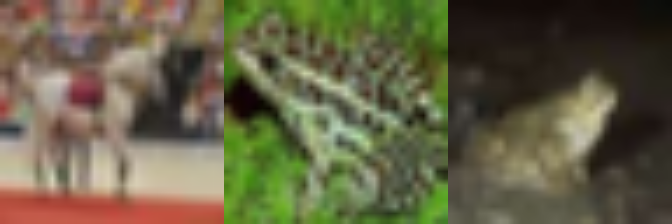

[7, 6, 6]


In [15]:
# Raw Image

n_view = 3
sample_images = [valid_dataset[i][0] for i in range(n_view)]
sample_targets = [valid_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

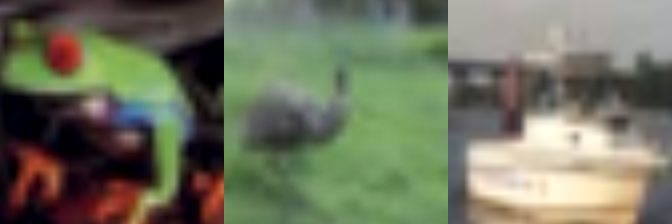

[6, 2, 8]


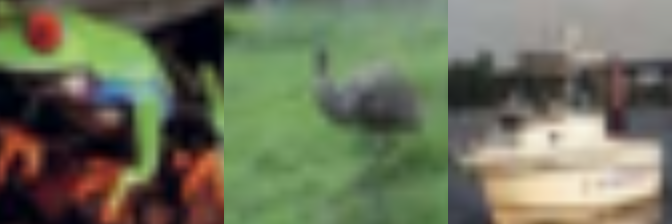

[6, 2, 8]


In [16]:
# Image transformed

n_view = 3
sample_images = [train_dataset[i][0] for i in range(n_view)]
sample_targets = [train_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

sample_images = [train_dataset[i][0] for i in range(n_view)]
sample_targets = [train_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Structure*

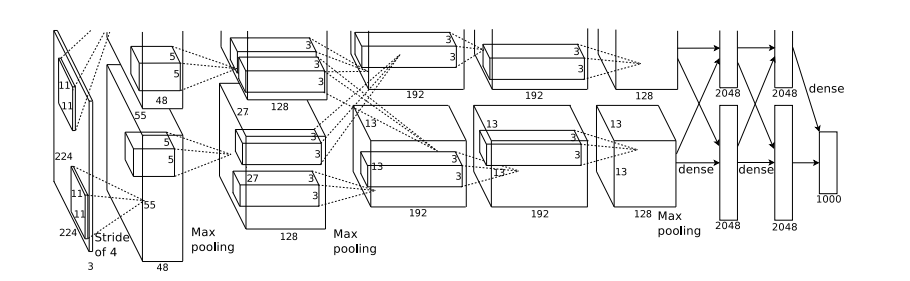

In [18]:
from torch.nn import  (
    Conv2d, ReLU,       MaxPool2d,  Flatten,
    Linear, Sequential, Dropout, LocalResponseNorm
)

class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential()
    self.net.add_module("Conv1", Sequential(
          Conv2d(in_channels=3, out_channels=48*2, kernel_size=11, stride=4),
          ReLU(),
          LocalResponseNorm(size=5, alpha=10e-4, beta=0.75, k=2),
          MaxPool2d(kernel_size=3, stride=2)
    ))
    self.net.add_module("Conv2", Sequential(
          Conv2d(in_channels=48*2, out_channels=128*2, kernel_size=5, padding=2),
          ReLU(),
          LocalResponseNorm(size=5, alpha=10e-4, beta=0.75, k=2),
          MaxPool2d(kernel_size=3, stride=2)
    ))
    self.net.add_module("Conv3", Sequential(  
        Conv2d(in_channels=128*2, out_channels=192*2, kernel_size=3, padding=1),
        ReLU()
    ))
    self.net.add_module("Conv4", Sequential(
        Conv2d(in_channels=192*2, out_channels=192*2, kernel_size=3, padding=1),
        ReLU()
    ))
    self.net.add_module("Conv5", Sequential(
        Conv2d(in_channels=192*2, out_channels=128*2, kernel_size=3, padding=1),
        ReLU(),
        MaxPool2d(kernel_size=3, stride=2)
    ))

    self.net.add_module("_", Flatten())

    self.net.add_module("FullyConnected6-8", Sequential(
        Linear(in_features=256*5*5, out_features=2048*2),
        Dropout(p=0.5),
        Linear(in_features=2048*2, out_features=4096*2),
        Dropout(p=0.5),
        Linear(in_features=4096*2, out_features=num_classes)
    ))

  def forward(self, x):
    return self.net(x)

print(AlexNet())

AlexNet(
  (net): Sequential(
    (Conv1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Conv2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Conv3): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Conv4): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Conv5): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dil

In [19]:
# Check forward path
X = torch.randn(1, 3, 224, 224)
for layer in AlexNet().net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Sequential output shape:	 torch.Size([1, 10])


### *Test / Validation Step*

In [20]:
def validate(model, dataloader, device=torch.device('cuda')):
  model.eval()
  acc = []

  with torch.no_grad():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      pred_labels = torch.argmax(preds, dim=1)
      acc.append((pred_labels == targets).type(torch.float32) .mean().item())
  
  return acc

### *Training Step*

In [21]:
def train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    valid_dataloader,
    num_epochs = 1,
    device = torch.device('cuda'),
    state_dict = None
):
  
  best_valid_acc = 0
  
  if state_dict is not None:
    model.load_state_dict(state_dict)

  for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    train_progress = tqdm(train_dataloader, position=0, leave=True)

    ## Train
    for images, targets in train_progress:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      loss = criterion(preds, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_value = loss.detach().item()
      batch_losses.append(loss_value)
      train_progress.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
      train_progress.set_postfix({'loss': loss_value})
    
    ## Validate and save the best model (if any)
    valid_acc = validate(model,  valid_dataloader)
    print(f"Train Loss: {np.mean(batch_losses):.3f}, Valid Acc:{np.mean(valid_acc):.3f}")
    if np.mean(valid_acc) > best_valid_acc:
      best_valid_acc = np.mean(valid_acc)
      torch.save(model.state_dict(), "model_state_dict.ckpt")

# **Section 2. Start Training**

### *Optimization Configuration and Training Stage*

In [ ]:
alexnet = AlexNet(num_classes=10)
alexnet.to(device)

optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

train(alexnet, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs=60)

Epoch [1/60]: 100%|██████████| 313/313 [02:20<00:00,  2.22it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.139


Epoch [2/60]: 100%|██████████| 313/313 [02:12<00:00,  2.36it/s, loss=1.94]


Train Loss: 2.104, Valid Acc:0.264


Epoch [3/60]: 100%|██████████| 313/313 [02:12<00:00,  2.36it/s, loss=1.71]


Train Loss: 1.843, Valid Acc:0.375


Epoch [4/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=1.5]


Train Loss: 1.605, Valid Acc:0.469


Epoch [5/60]: 100%|██████████| 313/313 [02:10<00:00,  2.40it/s, loss=1.19]


Train Loss: 1.440, Valid Acc:0.534


Epoch [6/60]: 100%|██████████| 313/313 [02:09<00:00,  2.42it/s, loss=1.24]


Train Loss: 1.294, Valid Acc:0.596


Epoch [7/60]: 100%|██████████| 313/313 [02:10<00:00,  2.41it/s, loss=1.06]


Train Loss: 1.156, Valid Acc:0.646


Epoch [8/60]: 100%|██████████| 313/313 [02:10<00:00,  2.41it/s, loss=1.06]


Train Loss: 1.049, Valid Acc:0.658


Epoch [9/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=1.11]


Train Loss: 0.943, Valid Acc:0.690


Epoch [10/60]: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s, loss=0.957]


Train Loss: 0.855, Valid Acc:0.724


Epoch [11/60]: 100%|██████████| 313/313 [02:09<00:00,  2.42it/s, loss=0.488]


Train Loss: 0.798, Valid Acc:0.729


Epoch [12/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.753]


Train Loss: 0.734, Valid Acc:0.744


Epoch [13/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.738]


Train Loss: 0.681, Valid Acc:0.772


Epoch [14/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.389]


Train Loss: 0.636, Valid Acc:0.773


Epoch [15/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.67]


Train Loss: 0.604, Valid Acc:0.779


Epoch [16/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.426]


Train Loss: 0.560, Valid Acc:0.792


Epoch [17/60]: 100%|██████████| 313/313 [02:06<00:00,  2.47it/s, loss=0.623]


Train Loss: 0.538, Valid Acc:0.795


Epoch [18/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.54]


Train Loss: 0.507, Valid Acc:0.814


Epoch [19/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.268]


Train Loss: 0.479, Valid Acc:0.807


Epoch [20/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.424]


Train Loss: 0.456, Valid Acc:0.811


Epoch [21/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.377]


Train Loss: 0.428, Valid Acc:0.822


Epoch [22/60]: 100%|██████████| 313/313 [02:08<00:00,  2.45it/s, loss=0.552]


Train Loss: 0.409, Valid Acc:0.806


Epoch [23/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.26]


Train Loss: 0.389, Valid Acc:0.819


Epoch [24/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.298]


Train Loss: 0.368, Valid Acc:0.830


Epoch [25/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.286]


Train Loss: 0.350, Valid Acc:0.830


Epoch [26/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.364]


Train Loss: 0.339, Valid Acc:0.831


Epoch [27/60]: 100%|██████████| 313/313 [02:06<00:00,  2.47it/s, loss=0.254]


Train Loss: 0.314, Valid Acc:0.840


Epoch [28/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.33]


Train Loss: 0.300, Valid Acc:0.834


Epoch [29/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.264]


Train Loss: 0.296, Valid Acc:0.830


Epoch [30/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.345]


Train Loss: 0.279, Valid Acc:0.835


Epoch [31/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.219]


Train Loss: 0.269, Valid Acc:0.834


Epoch [32/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.148]


Train Loss: 0.259, Valid Acc:0.832


Epoch [33/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.189]


Train Loss: 0.238, Valid Acc:0.834


Epoch [34/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.288]


Train Loss: 0.237, Valid Acc:0.834


Epoch [35/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.304]


Train Loss: 0.231, Valid Acc:0.838


Epoch [36/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.243]


Train Loss: 0.217, Valid Acc:0.839


Epoch [37/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.3]


Train Loss: 0.214, Valid Acc:0.837


Epoch [38/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.267]


Train Loss: 0.206, Valid Acc:0.836


Epoch [39/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.243]


Train Loss: 0.189, Valid Acc:0.841


Epoch [40/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.157]


Train Loss: 0.187, Valid Acc:0.849


Epoch [41/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.177]


Train Loss: 0.179, Valid Acc:0.836


Epoch [42/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.324]


Train Loss: 0.178, Valid Acc:0.842


Epoch [43/60]: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s, loss=0.107]


Train Loss: 0.171, Valid Acc:0.847


Epoch [44/60]: 100%|██████████| 313/313 [02:07<00:00,  2.46it/s, loss=0.224]


Train Loss: 0.155, Valid Acc:0.837


Epoch [45/60]: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s, loss=0.179]


Train Loss: 0.161, Valid Acc:0.848


Epoch [46/60]: 100%|██████████| 313/313 [02:05<00:00,  2.49it/s, loss=0.111]


Train Loss: 0.150, Valid Acc:0.852


Epoch [47/60]: 100%|██████████| 313/313 [02:05<00:00,  2.49it/s, loss=0.149]


Train Loss: 0.145, Valid Acc:0.841


Epoch [48/60]:  82%|████████▏ | 256/313 [01:42<00:23,  2.47it/s, loss=0.212]

### *Testing Stage*

In [ ]:
test_model = AlexNet(num_classes=10)
test_model.to(device)
best_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(best_state_dict)
print("Final Acc:", np.mean(validate(test_model, test_dataloader)))